In [1]:
!pip install virtualenv
!virtualenv XAIEnv

created virtual environment CPython3.10.10.final.0-64 in 1138ms
  creator CPython3Posix(dest=/kaggle/working/XAIEnv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==23.0.1, setuptools==67.4.0, wheel==0.38.4
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


# Explain Classification result from ResNet

In [2]:
%%time
!source /kaggle/working/XAIEnv/bin/activate; pip install numba torch captum torchvision quantus omnixai[vision] dash jupyter_dash dash_bootstrap_components scikit-learn==1.1.3 numpy==1.22.4 Pillow fastcore -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.1/283.1 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.8/543.8 kB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 85.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.6/220.6 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import sys
sys.path.append("XAIEnv/lib/python3.10/site-packages")

In [4]:
import torch
# import quantus
from captum.attr import (
    Saliency, # A baseline approach for computing input attribution
    GradientShap, 
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
    GuidedGradCam,
    GuidedBackprop,
    Saliency,
    LimeBase,
    FeatureAblation,
    Occlusion,
    LRP,
    visualization as viz
)
from PIL import Image
import torchvision
from torchvision import transforms
import json
import requests
from io import BytesIO
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
from torchvision import models
import seaborn as sns
import scipy
import skimage
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
warnings.filterwarnings('ignore')
import gc
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
cpu = torch.device("cpu")
print(f'Using {device} for inference')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using cuda for inference


In [5]:
torch.manual_seed(123)
np.random.seed(123)

# Setup datasets

In [6]:
resize_image = transforms.Compose([
  transforms.Resize(128),
#   transforms.CenterCrop(299),
])

transform = transforms.Compose([            
  transforms.ToTensor(),
  resize_image,
  transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
  )
])

mask_transform = transforms.Compose([            
  transforms.ToTensor(),
  resize_image,
])

In [7]:
from torch.utils.data import Dataset

class PneumothoraxImageDataset(Dataset):
    def __init__(self, images, targets, masks, transform, mask_transform):
        self.masks = masks
        self.images = images
        self.targets = targets
        self.transform = transform
        self.mask_transform = mask_transform
        

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = np.asarray(Image.open(self.images[idx]).convert('RGB'))
        mask = np.asarray(Image.open(self.masks[idx]).convert('RGB'))
        label = self.targets[idx]
        if self.transform:
          image = self.transform(image)
        if self.mask_transform:
          mask = self.mask_transform(mask)
        return image, mask, label

In [8]:
use_kaggle = True
kaggle_main_path = '/kaggle/input/pneumothorax-chest-xray-images-and-masks'
colab_main_path = '/content/datasets'
main_path = f'{kaggle_main_path if use_kaggle else colab_main_path}/siim-acr-pneumothorax'
import os
import pandas as pd
# train_data = pd.read_csv(os.path.join(main_path, 'stage_1_train_images.csv'))
test_data = pd.read_csv(os.path.join(main_path, 'stage_1_test_images.csv'))
# Just load only abnormal cases
# test_abnormal = test_data.loc[test_data.has_pneumo == 1]

# Load all cases
test_abnormal = test_data

# train_data['images'] = train_data['new_filename'].apply(lambda x: os.path.join(main_path, 'png_images', x))
# train_data['masks'] = train_data['new_filename'].apply(lambda x: os.path.join(main_path, 'png_masks', x))

test_abnormal['images'] = test_abnormal['new_filename'].apply(lambda x: os.path.join(main_path, 'png_images', x))
test_abnormal['masks'] = test_abnormal['new_filename'].apply(lambda x: os.path.join(main_path, 'png_masks', x))

images = test_abnormal['images'].tolist()
masks = test_abnormal['masks'].tolist()
targets = test_abnormal['has_pneumo'].tolist()

In [9]:
dataset = PneumothoraxImageDataset(images, targets, masks, transform=transform, mask_transform=mask_transform)
ds_loader = torch.utils.data.DataLoader(dataset, batch_size=16, num_workers=4)

## UTIL FUNCS

### Bellow is the override of an visualization implementation due to the orginal version from the captum module cause bug when config matplotlib grid_b

In [10]:
from matplotlib import cm, colors, pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.figure import Figure
from matplotlib.pyplot import axis, figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import ndarray
from enum import Enum
from typing import Any, Iterable, List, Optional, Tuple, Union


try:
    from IPython.display import display, HTML

    HAS_IPYTHON = True
except ImportError:
    HAS_IPYTHON = False


class ImageVisualizationMethod(Enum):
    heat_map = 1
    blended_heat_map = 2
    original_image = 3
    masked_image = 4
    alpha_scaling = 5


class TimeseriesVisualizationMethod(Enum):
    overlay_individual = 1
    overlay_combined = 2
    colored_graph = 3


class VisualizeSign(Enum):
    positive = 1
    absolute_value = 2
    negative = 3
    all = 4


def _prepare_image(attr_visual: ndarray):
    return np.clip(attr_visual.astype(int), 0, 255)


def _normalize_scale(attr: ndarray, scale_factor: float):
    assert scale_factor != 0, "Cannot normalize by scale factor = 0"
    if abs(scale_factor) < 1e-5:
        warnings.warn(
            "Attempting to normalize by value approximately 0, visualized results"
            "may be misleading. This likely means that attribution values are all"
            "close to 0."
        )
    attr_norm = attr / scale_factor
    return np.clip(attr_norm, -1, 1)


def _cumulative_sum_threshold(values: ndarray, percentile: Union[int, float]):
    # given values should be non-negative
    assert percentile >= 0 and percentile <= 100, (
        "Percentile for thresholding must be " "between 0 and 100 inclusive."
    )
    sorted_vals = np.sort(values.flatten())
    cum_sums = np.cumsum(sorted_vals)
    threshold_id = np.where(cum_sums >= cum_sums[-1] * 0.01 * percentile)[0][0]
    return sorted_vals[threshold_id]


def _normalize_attr(
    attr: ndarray,
    sign: str,
    outlier_perc: Union[int, float] = 2,
    reduction_axis: Optional[int] = None,
):
    attr_combined = attr
    if reduction_axis is not None:
        attr_combined = np.sum(attr, axis=reduction_axis)

    # Choose appropriate signed values and rescale, removing given outlier percentage.
    if VisualizeSign[sign] == VisualizeSign.all:
        threshold = _cumulative_sum_threshold(np.abs(attr_combined), 100 - outlier_perc)
    elif VisualizeSign[sign] == VisualizeSign.positive:
        attr_combined = (attr_combined > 0) * attr_combined
        threshold = _cumulative_sum_threshold(attr_combined, 100 - outlier_perc)
    elif VisualizeSign[sign] == VisualizeSign.negative:
        attr_combined = (attr_combined < 0) * attr_combined
        threshold = -1 * _cumulative_sum_threshold(
            np.abs(attr_combined), 100 - outlier_perc
        )
    elif VisualizeSign[sign] == VisualizeSign.absolute_value:
        attr_combined = np.abs(attr_combined)
        threshold = _cumulative_sum_threshold(attr_combined, 100 - outlier_perc)
    else:
        raise AssertionError("Visualize Sign type is not valid.")
    return _normalize_scale(attr_combined, threshold)


def visualize_image_attr(
    attr: ndarray,
    original_image: Union[None, ndarray] = None,
    method: str = "heat_map",
    sign: str = "absolute_value",
    plt_fig_axis: Union[None, Tuple[figure, axis]] = None,
    outlier_perc: Union[int, float] = 2,
    cmap: Union[None, str] = None,
    alpha_overlay: float = 0.5,
    show_colorbar: bool = False,
    title: Union[None, str] = None,
    fig_size: Tuple[int, int] = (6, 6),
    use_pyplot: bool = True,
):
    r"""
    Visualizes attribution for a given image by normalizing attribution values
    of the desired sign (positive, negative, absolute value, or all) and displaying
    them using the desired mode in a matplotlib figure.

    Args:

        attr (numpy.ndarray): Numpy array corresponding to attributions to be
                    visualized. Shape must be in the form (H, W, C), with
                    channels as last dimension. Shape must also match that of
                    the original image if provided.
        original_image (numpy.ndarray, optional): Numpy array corresponding to
                    original image. Shape must be in the form (H, W, C), with
                    channels as the last dimension. Image can be provided either
                    with float values in range 0-1 or int values between 0-255.
                    This is a necessary argument for any visualization method
                    which utilizes the original image.
                    Default: None
        method (str, optional): Chosen method for visualizing attribution.
                    Supported options are:

                    1. `heat_map` - Display heat map of chosen attributions

                    2. `blended_heat_map` - Overlay heat map over greyscale
                       version of original image. Parameter alpha_overlay
                       corresponds to alpha of heat map.

                    3. `original_image` - Only display original image.

                    4. `masked_image` - Mask image (pixel-wise multiply)
                       by normalized attribution values.

                    5. `alpha_scaling` - Sets alpha channel of each pixel
                       to be equal to normalized attribution value.

                    Default: `heat_map`
        sign (str, optional): Chosen sign of attributions to visualize. Supported
                    options are:

                    1. `positive` - Displays only positive pixel attributions.

                    2. `absolute_value` - Displays absolute value of
                       attributions.

                    3. `negative` - Displays only negative pixel attributions.

                    4. `all` - Displays both positive and negative attribution
                       values. This is not supported for `masked_image` or
                       `alpha_scaling` modes, since signed information cannot
                       be represented in these modes.

                    Default: `absolute_value`
        plt_fig_axis (tuple, optional): Tuple of matplotlib.pyplot.figure and axis
                    on which to visualize. If None is provided, then a new figure
                    and axis are created.
                    Default: None
        outlier_perc (float or int, optional): Top attribution values which
                    correspond to a total of outlier_perc percentage of the
                    total attribution are set to 1 and scaling is performed
                    using the minimum of these values. For sign=`all`, outliers
                    and scale value are computed using absolute value of
                    attributions.
                    Default: 2
        cmap (str, optional): String corresponding to desired colormap for
                    heatmap visualization. This defaults to "Reds" for negative
                    sign, "Blues" for absolute value, "Greens" for positive sign,
                    and a spectrum from red to green for all. Note that this
                    argument is only used for visualizations displaying heatmaps.
                    Default: None
        alpha_overlay (float, optional): Alpha to set for heatmap when using
                    `blended_heat_map` visualization mode, which overlays the
                    heat map over the greyscaled original image.
                    Default: 0.5
        show_colorbar (bool, optional): Displays colorbar for heatmap below
                    the visualization. If given method does not use a heatmap,
                    then a colormap axis is created and hidden. This is
                    necessary for appropriate alignment when visualizing
                    multiple plots, some with colorbars and some without.
                    Default: False
        title (str, optional): Title string for plot. If None, no title is
                    set.
                    Default: None
        fig_size (tuple, optional): Size of figure created.
                    Default: (6,6)
        use_pyplot (bool, optional): If true, uses pyplot to create and show
                    figure and displays the figure after creating. If False,
                    uses Matplotlib object oriented API and simply returns a
                    figure object without showing.
                    Default: True.

    Returns:
        2-element tuple of **figure**, **axis**:
        - **figure** (*matplotlib.pyplot.figure*):
                    Figure object on which visualization
                    is created. If plt_fig_axis argument is given, this is the
                    same figure provided.
        - **axis** (*matplotlib.pyplot.axis*):
                    Axis object on which visualization
                    is created. If plt_fig_axis argument is given, this is the
                    same axis provided.

    Examples::

        >>> # ImageClassifier takes a single input tensor of images Nx3x32x32,
        >>> # and returns an Nx10 tensor of class probabilities.
        >>> net = ImageClassifier()
        >>> ig = IntegratedGradients(net)
        >>> # Computes integrated gradients for class 3 for a given image .
        >>> attribution, delta = ig.attribute(orig_image, target=3)
        >>> # Displays blended heat map visualization of computed attributions.
        >>> _ = visualize_image_attr(attribution, orig_image, "blended_heat_map")
    """
    # Create plot if figure, axis not provided
    if plt_fig_axis is not None:
        plt_fig, plt_axis = plt_fig_axis
    else:
        if use_pyplot:
            plt_fig, plt_axis = plt.subplots(figsize=fig_size)
        else:
            plt_fig = Figure(figsize=fig_size)
            plt_axis = plt_fig.subplots()

    if original_image is not None:
        if np.max(original_image) <= 1.0:
            original_image = _prepare_image(original_image * 255)
    elif ImageVisualizationMethod[method] != ImageVisualizationMethod.heat_map:
        raise ValueError(
            "Original Image must be provided for"
            "any visualization other than heatmap."
        )

    # Remove ticks and tick labels from plot.
    plt_axis.xaxis.set_ticks_position("none")
    plt_axis.yaxis.set_ticks_position("none")
    plt_axis.set_yticklabels([])
    plt_axis.set_xticklabels([])
    plt_axis.grid(visible=False)

    heat_map = None
    # Show original image
    if ImageVisualizationMethod[method] == ImageVisualizationMethod.original_image:
        assert (
            original_image is not None
        ), "Original image expected for original_image method."
        if len(original_image.shape) > 2 and original_image.shape[2] == 1:
            original_image = np.squeeze(original_image, axis=2)
        plt_axis.imshow(original_image)
    else:
        # Choose appropriate signed attributions and normalize.
        norm_attr = _normalize_attr(attr, sign, outlier_perc, reduction_axis=2)

        # Set default colormap and bounds based on sign.
        if VisualizeSign[sign] == VisualizeSign.all:
            default_cmap = LinearSegmentedColormap.from_list(
                "RdWhGn", ["red", "white", "green"]
            )
            vmin, vmax = -1, 1
        elif VisualizeSign[sign] == VisualizeSign.positive:
            default_cmap = "Greens"
            vmin, vmax = 0, 1
        elif VisualizeSign[sign] == VisualizeSign.negative:
            default_cmap = "Reds"
            vmin, vmax = 0, 1
        elif VisualizeSign[sign] == VisualizeSign.absolute_value:
            default_cmap = "Blues"
            vmin, vmax = 0, 1
        else:
            raise AssertionError("Visualize Sign type is not valid.")
        cmap = cmap if cmap is not None else default_cmap

        # Show appropriate image visualization.
        if ImageVisualizationMethod[method] == ImageVisualizationMethod.heat_map:
            heat_map = plt_axis.imshow(norm_attr, cmap=cmap, vmin=vmin, vmax=vmax)
        elif (
            ImageVisualizationMethod[method]
            == ImageVisualizationMethod.blended_heat_map
        ):
            assert (
                original_image is not None
            ), "Original Image expected for blended_heat_map method."
            plt_axis.imshow(np.mean(original_image, axis=2), cmap="gray")
            heat_map = plt_axis.imshow(
                norm_attr, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha_overlay
            )
        elif ImageVisualizationMethod[method] == ImageVisualizationMethod.masked_image:
            assert VisualizeSign[sign] != VisualizeSign.all, (
                "Cannot display masked image with both positive and negative "
                "attributions, choose a different sign option."
            )
            plt_axis.imshow(
                _prepare_image(original_image * np.expand_dims(norm_attr, 2))
            )
        elif ImageVisualizationMethod[method] == ImageVisualizationMethod.alpha_scaling:
            assert VisualizeSign[sign] != VisualizeSign.all, (
                "Cannot display alpha scaling with both positive and negative "
                "attributions, choose a different sign option."
            )
            plt_axis.imshow(
                np.concatenate(
                    [
                        original_image,
                        _prepare_image(np.expand_dims(norm_attr, 2) * 255),
                    ],
                    axis=2,
                )
            )
        else:
            raise AssertionError("Visualize Method type is not valid.")

    # Add colorbar. If given method is not a heatmap and no colormap is relevant,
    # then a colormap axis is created and hidden. This is necessary for appropriate
    # alignment when visualizing multiple plots, some with heatmaps and some
    # without.
    if show_colorbar:
        axis_separator = make_axes_locatable(plt_axis)
        colorbar_axis = axis_separator.append_axes("bottom", size="5%", pad=0.1)
        if heat_map:
            plt_fig.colorbar(heat_map, orientation="horizontal", cax=colorbar_axis)
        else:
            colorbar_axis.axis("off")
    if title:
        plt_axis.set_title(title)

    if use_pyplot:
        plt.show()

    return plt_fig, plt_axis

## Setup Blackbox & XAI methods

In [11]:
kaggle_checkpoint_path = '/kaggle/input/xai-pretrained-blackbox'
colab_checkpoint_path = '/content/datasets/'
checkpoint = torch.load(f'{kaggle_checkpoint_path if use_kaggle else colab_checkpoint_path}/inception_cp.pth')
blackbox = models.inception_v3()
blackbox.load_state_dict(checkpoint)
for parameter in blackbox.parameters():
    parameter.requires_grad = False
blackbox = torch.nn.DataParallel(blackbox.cuda())
blackbox.eval().to(device)

DataParallel(
  (module): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): Bas

In [12]:
sl = Saliency(blackbox)
guided_gc = GuidedGradCam(blackbox, blackbox.module.Mixed_7c)
gbp = GuidedBackprop(blackbox)
lrp = LRP(blackbox)
dls = DeepLiftShap(blackbox)
dl = DeepLift(blackbox)
gs = GradientShap(blackbox)
ig = IntegratedGradients(blackbox)
ablator = FeatureAblation(blackbox)
occlusion = Occlusion(blackbox)
smoothgrad = NoiseTunnel(ig)

# Generate Explainations

In [13]:
rand_img_dist = torch.rand((1, 3, 128, 128)).to(device)
rand_img_dist.shape

torch.Size([1, 3, 128, 128])

In [14]:
dataset_labels = { 0: 'normal', 1: 'Pneumothorax' }

In [15]:
xai_methods = {
  "Saliency": { "method": sl , "options": {}},
  "GuidedGradCam": { "method": guided_gc, "options": {'interpolate_mode': 'area'}},
  "GuidedBackprop": { "method": gbp, "options": {}},
  "LRP": { "method": lrp, "options": {}},
  # "DeepLiftShap": { "method": dls, "options": {}},
  # "DeepLift": { "method": dl, "options": {}},
  "GradientShap": { "method": gs, "options": { 'n_samples': 16, 'stdevs': 0.0001, 'baselines': rand_img_dist }},
  "IntegratedGradients": { "method": ig, "options": { 'n_steps' : 100, 'internal_batch_size': 1 }, 'baselines': rand_img_dist },
  # "FeatureAblation": { "method": ablator, "options": {}},
  "Occlusion": { "method": occlusion, "options": { 'sliding_window_shapes': (3,8, 8), 'strides': (3, 4, 4)}},
  "SmoothGrad": {"method": smoothgrad, "options": {"nt_type": "smoothgrad"}}
}

In [16]:
def compute_mean_disagreement(output1, output2, metric):
    metrics = []
    with torch.no_grad():
        for o1, o2 in zip(output1, output2):
            filtered1 = o1.cpu().numpy()
            filtered2 = o2.cpu().numpy()
            metrics.append(metric(filtered1, filtered2))
    return np.array(metrics).mean()

In [17]:
from tqdm import tqdm
import gc

def visualize_explain_of(xai_methods, x, mask, y, blackbox):
  with torch.no_grad():
    output = torch.nn.functional.softmax(blackbox(x), dim=1)
    _, indices = torch.topk(output, k=1, dim = 1)
  indices = torch.flatten(indices)
  num_methods = len(xai_methods.items())
  for idx, img in tqdm(enumerate(x)):
    target = indices[idx]
    if target.item() == 0:
      continue
    fig, axes = plt.subplots(1, num_methods + 1, figsize = (48, 6))
    axes[0].imshow(np.transpose(mask[idx].detach().numpy(), (1, 2, 0)))
    for method_idx, (method_name, parameters) in enumerate(xai_methods.items()):
      attributions = parameters["method"].attribute(img.unsqueeze(0), target=target, **parameters["options"])
      # Convert the compute attribution tensor into an image-like numpy array
      attribution = np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0))
      visualize_image_attr(attribution, np.transpose(img.cpu().detach().numpy(), (1, 2,0)), "blended_heat_map", sign="positive", title=method_name, use_pyplot=False, plt_fig_axis=(fig, axes[1 + method_idx]))
      torch.cuda.empty_cache()
      gc.collect()
    plt.show()

In [18]:
# visualize_explain_of(xai_methods, x.to(device), mask, y, blackbox)

# Experiments

## Utility functions

In [19]:
def get_explanation(xai_config, batch, targets):
    """Return the explanation of an XAI model for an input batch
    """
    xai_model = xai_config['method']
    options = xai_config['options']
    attribution = xai_model.attribute(batch, target=targets, **options)
    return attribution.mean(dim=1)

In [20]:
def normalize(x):
    t = (x - np.min(x)) / (np.max(x) - np.min(x))
    return t

In [21]:
def normalize_sum_to_one(x):
    norm = normalize(x)
    return norm / norm.sum()

In [22]:
def compute_mean_disagreement(exp1, exp2, metric):
    metrics = []
    for e1, e2 in zip(exp1, exp2):
        metrics.append(metric(e1.cpu().numpy(), e2.cpu().numpy()))
    return np.array(metrics).mean()

In [23]:
# Obsolete
def compute_disagreement_heatmap(list_methods, batch, blackbox, metric):
    size = len(list_methods)
    result = np.empty((size, size))
    with torch.no_grad():
        output = torch.nn.functional.softmax(blackbox(batch), dim=1)
        _, indices = torch.topk(output, k=1, dim = 1)
    indices = torch.flatten(indices)

    attributions = []
    for method in list_methods:
        explanation = get_explanation(method, batch.to(device), indices.to(device))
        gc.collect()
        torch.cuda.empty_cache()
        attributions.append(explanation)

    for j in range(size):
        for i in range(size):
            if i >= j:
                result[i, j] = compute_mean_disagreement(attributions[i], attributions[j], metric)
            else:
                result[i, j] = result[j, i]
    return result

## Defining Metrics

### Hellinger distance

In [24]:
def hellinger_distance(x, y):
    return 1 / np.sqrt(2) * np.sqrt(np.sum((np.sqrt(normalize_sum_to_one(x)) - np.sqrt(normalize_sum_to_one(y))) ** 2))

### Metrics from the paper _The Disagreement Problem in Explainable Machine Learning_

In [25]:
def feature_agreement(x, y, k=1638):
    _, i1 = torch.topk(torch.Tensor(x).flatten().abs(), k)
    _, i2 = torch.topk(torch.Tensor(y).flatten().abs(), k)
    i1 = set(torch.unique(i1).tolist())
    i2 = set(torch.unique(i2).tolist())
    intersect = len(i1.intersection(i2))
    return 1.0 * intersect / k

In [26]:
def sign_agreement(x, y, k=1638):
    x_flatten = x.flatten()
    y_flatten = y.flatten()
    x_topk = np.argpartition(np.absolute(x_flatten), -k)[-k:]
    y_topk = np.argpartition(np.absolute(y_flatten), -k)[-k:]
    
    intersect = np.intersect1d(x_topk, y_topk)
    same_sign = np.asarray(list(map(lambda ind: x_flatten[ind] * y_flatten[ind] > 0, intersect)))
    return same_sign.sum() * 1.0 / k

### IoU

In [27]:
def iou(x, y, threshold = 0.25):
    x_bin = x > threshold
    y_bin = y > threshold
    intersection = x_bin * y_bin
    union = x_bin + y_bin
    return 0 if union.sum() == 0 else intersection.sum() / float(union.sum())

In [28]:
def positive_iou(x, y): return iou(x, y, 0)

### Structural similarity index

In [29]:
def ssim(x, y):
    return skimage.metrics.structural_similarity(normalize(x), normalize(y), data_range=1.0)

## Evaluation

Evaluate the blackbox over the test set.

In [30]:
%%time
indices = []
y_true = []
im_masks = []
with torch.no_grad():
    for data in ds_loader:
        batch = data[0]
        m = data[1]
        y = data[2]
        output = torch.nn.functional.softmax(blackbox(batch.to(device)), dim=1)
        _, index = torch.topk(output, k=1, dim=1)
        
        indices.append(index.flatten())
        y_true.append(y)
        im_masks.append(m)

indices = torch.concat(indices)
y_true = torch.concat(y_true)
im_masks = torch.concat(im_masks)

CPU times: user 13.8 s, sys: 2.67 s, total: 16.5 s
Wall time: 58.3 s


Assess the blackbox performance. This is the confusion matrix, accuracy and F1-score.

Accuracy: 0.6880466472303207
F1-score: 0.3162939297124601


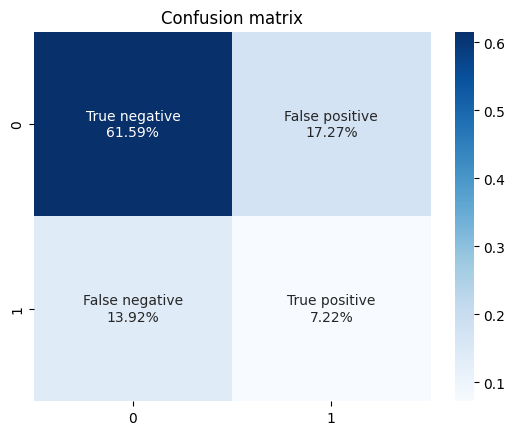

In [31]:
y_true = np.array(y_true)
y_pred = indices.cpu().detach().numpy()

# Accuracy
print(f'Accuracy: {accuracy_score(y_true, y_pred)}')

# F1 score
print(f'F1-score: {f1_score(y_true, y_pred)}')

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='all')
cm_labels = [f'{label}\n{"{0:.2f}%".format(val * 100)}' for label, val in zip(['True negative', 'False positive', 'False negative', 'True positive'], cm.flatten())]
cm_labels = np.asarray(cm_labels).reshape(2, 2)
sns.heatmap(cm, annot=cm_labels, fmt='', cmap='Blues').set(title='Confusion matrix')
plt.show()

## Generating explanations

Generate explanations for all test examples for each interested methods.

In [32]:
def get_explanations(xai_methods_dict, methods, ds_loader, indices, gpu_device):
    explanations = {}
    indices = indices.to(gpu_device)
    
    for method in methods:
        explanations[method] = []

    for method in methods:
        for i, data in enumerate(ds_loader):
            batch = data[0]
            explanation = get_explanation(xai_methods_dict[method], batch.to(gpu_device), indices[i])
            explanation = explanation.cpu().detach()
            explanations[method].append(explanation)
    
    return explanations

Gradient-based methods.

In [33]:
%%time
gradient_methods = ['Saliency', 'LRP', 'GradientShap', 'GuidedGradCam', 'GuidedBackprop']
gradient_explanations = get_explanations(xai_methods, gradient_methods, ds_loader, indices, device)

CPU times: user 1min 46s, sys: 4.27 s, total: 1min 51s
Wall time: 4min 34s


Perturbation-based methods.

In [34]:
%%time
perturbation_methods = ['IntegratedGradients']
perturbation_explanations = get_explanations(xai_methods, perturbation_methods, ds_loader, indices, device)

CPU times: user 17min 15s, sys: 47.1 s, total: 18min 3s
Wall time: 13min 12s


Concatenate explanations of each method into a single tensor.

In [35]:
explanations = {**gradient_explanations, **perturbation_explanations}
methods = gradient_methods + perturbation_methods
for method in methods:
    exp = explanations[method]
    for i in range(len(exp)):
        exp[i] = exp[i].cpu().detach()
    explanations[method] = torch.cat(exp)

In [36]:
# Obsolete
def get_topk_mask(exp, k):
    temp = torch.clone(exp)
    _, temp_ind = torch.topk(temp.flatten(), k)
    temp *= 0
    z = np.unravel_index(temp_ind, temp.shape)
    for i, j in zip(z[0], z[1]):
        temp[i, j] = 1
    return temp

## Visualization

Compute average disagreement for a given metric.

In [37]:
def compute_heatmap(methods, explanations, metric):
    size = len(methods)
    result = np.empty((size, size))

    for j in range(size):
        for i in range(size):
            exp1 = explanations[methods[i]]
            exp2 = explanations[methods[j]]
            if i >= j:
                result[i, j] = compute_mean_disagreement(exp1, exp2, metric)
            else:
                result[i, j] = result[j, i]
    return result

In [38]:
def visualize(hm, title):
    return sns.heatmap(hm, annot=True, xticklabels=methods, yticklabels=methods).set(title=title)

### Feature Agreement

In [39]:
%%time
heatmap_fa = compute_heatmap(methods, explanations, metric=feature_agreement)

CPU times: user 47.8 s, sys: 39.1 ms, total: 47.9 s
Wall time: 48 s


[Text(0.5, 1.0, 'Feature Agreement')]

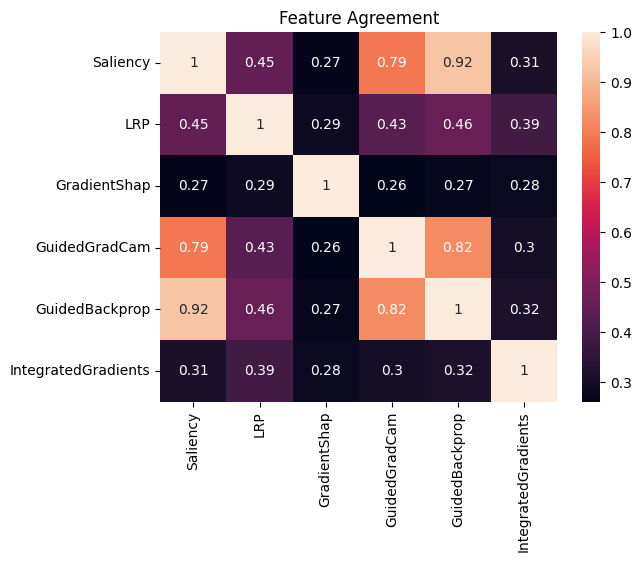

In [40]:
visualize(heatmap_fa, title='Feature Agreement')

### Sign agreements

In [41]:
%%time
heatmap_sa = compute_heatmap(methods, explanations, metric=sign_agreement)

CPU times: user 1min 57s, sys: 95 ms, total: 1min 57s
Wall time: 1min 57s


[Text(0.5, 1.0, 'Sign Agreement')]

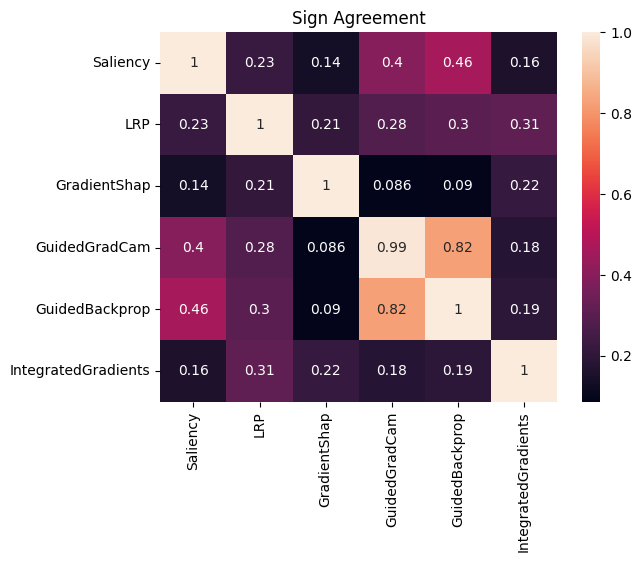

In [42]:
visualize(heatmap_sa, title='Sign Agreement')

### IoU

In [43]:
%%time
heatmap_iou = compute_heatmap(methods, explanations, metric=positive_iou)

CPU times: user 2.15 s, sys: 2.8 ms, total: 2.15 s
Wall time: 2.15 s


[Text(0.5, 1.0, 'IoU')]

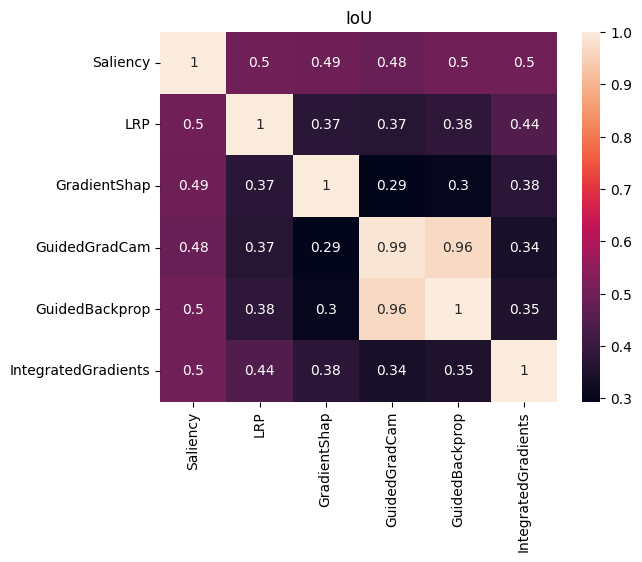

In [44]:
visualize(heatmap_iou, title='IoU')

### SSIM

In [45]:
%%time
heatmap_ssim = compute_heatmap(methods, explanations, metric=ssim)

CPU times: user 43.6 s, sys: 65.5 ms, total: 43.7 s
Wall time: 43.8 s


[Text(0.5, 1.0, 'Structural Similarity Index')]

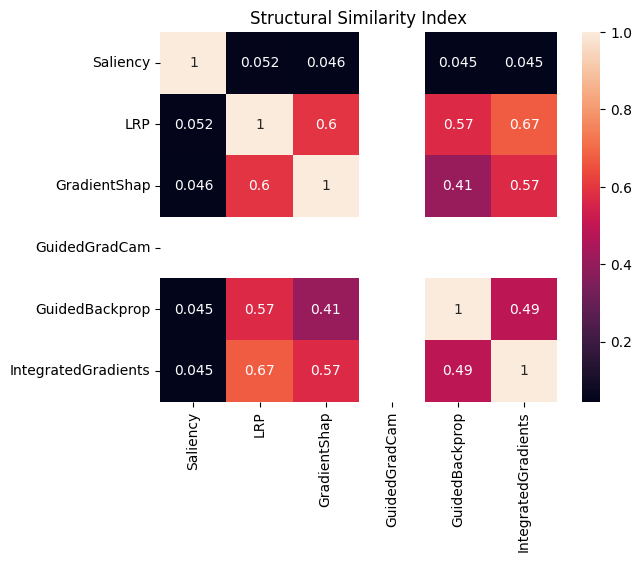

In [46]:
visualize(heatmap_ssim, 'Structural Similarity Index')